Подключаем библиотеки и cuda

In [1]:
import os
import glob
import random

import torch
import numpy as np
import cv2

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms

import torch.nn.functional as F

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device

'cuda'

Класс для датасета

In [3]:
class ColorDataset(Dataset):
    
    def __init__(self, rootdir, transform) -> None:
        super().__init__()
        self.class_names = os.listdir(rootdir)
        self.class_idx = [i for i in range(len(self.class_names))]
        self.transform = transform
        self.images_pathes = []
        self.images_clas_names = []

        for cls_name in self.class_names:
            sub_root = os.path.join(rootdir, cls_name)
            self.images_pathes.extend(glob.glob(os.path.join(sub_root, '*.jpg')))
            self.images_clas_names.append(cls_name)

        random.shuffle(self.images_pathes)
            
    def __len__(self):
        return len(self.images_pathes)
    
    def __getitem__(self, index) -> tuple:

        img_path = self.images_pathes[index]
        image = cv2.imread(img_path)
        img_folder_pth = os.path.split(img_path)[0]
        cls_name = os.path.split(img_folder_pth)[-1]
        label = self.class_names.index(cls_name)
        
        if self.transform:
            image = self.transform(image)

        return (image, label)

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize(mean = 0.5, std = 0.5)
    ]
)

Данные test хранятся в папке без деления на классы, что не даёт удобно проверить результаты. Для обучения данные разделим train на 2 набора train(80%) и test(20%).

In [5]:
import os

# Получить текущую директорию
current_directory = os.getcwd()

# Создать относительный путь
DATA_PATH = os.path.join(current_directory, 'data')


In [6]:
classes = {n: cls for n,cls in enumerate(os.listdir(DATA_PATH))}
classes_invert = {value:key for key, value in classes.items() }

batch_size = 64
dataset = ColorDataset(DATA_PATH, transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
for x,y in train_loader:
    print(x.shape)
    print(y)
    break

torch.Size([64, 3, 224, 224])
tensor([ 6,  2,  8,  7, 11, 11, 10, 10,  3,  7,  9,  9, 11, 10,  8, 10,  1,  6,
         5,  3,  2,  3,  3,  9,  3,  4,  2,  2,  3,  7,  0,  9,  2,  9,  9,  6,
         1,  1,  3,  2,  5,  2,  8,  3,  2,  9,  1,  7,  4, 11, 11,  1,  1, 11,
        11,  4,  1, 10,  6,  9, 10,  3,  2,  2])


In [8]:
# выход с последнего слоя
len(classes.values())       

12

Класс для модели

In [9]:
class ColorClassificator(nn.Module):
    def __init__(self):
        super(ColorClassificator, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(150528, 1024)  # Входная размерность для 224x224 с 3 каналами
        self.linear_2 = nn.Linear(1024, 512)
        self.linear_3 = nn.Linear(512, 256)
        self.linear_4 = nn.Linear(256, 128)
        self.linear_5 = nn.Linear(128, 12)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.linear_2(x)
        x = F.relu(x)
        x = self.linear_3(x)
        x = F.relu(x)
        x = self.linear_4(x)
        x = F.relu(x)
        x = self.linear_5(x)
        
        return x

In [10]:
model = ColorClassificator()
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()

optimizator = torch.optim.Adam(model.parameters(), lr=0.001,)

In [11]:
def val(model, test_loader):
    model.eval()
    tp = 0
    total = 0

    for x,y in test_loader:
        y = y.to(device)
        pred = torch.argmax(model(x.to(device)), dim=1)
        tp += int((pred == y).sum().to('cpu'))
        total +=len(pred)
    
    return tp/total

def train(dataloader, model, loss_fn, op_fn, epoch):
    for ep in range(epoch):
        for step, (x, y) in enumerate(dataloader):

            y_pred = model(x.to(device))
            loss = loss_fn(y_pred.to(device), y.to(device))

            op_fn.zero_grad()
            loss.backward()
            op_fn.step()

            if step%100 == 0:
                loss, current = loss.item(), (ep+1)*(step+1)*batch_size
                print(f"loss = {loss}, samples = {current}")

        acc = val(model, test_loader)
        print('accuracy', acc)

        torch.save(model, f'color_classifier_{epoch}_epo_{acc}_acc.pt')

In [12]:
train(train_loader, model, loss_function, optimizator, 6)

loss = 2.4854283332824707, samples = 64
accuracy 0.5096153846153846
loss = 1.6857939958572388, samples = 128
accuracy 0.6049679487179487
loss = 1.2442126274108887, samples = 192
accuracy 0.5857371794871795
loss = 1.3432822227478027, samples = 256
accuracy 0.6065705128205128
loss = 1.1811554431915283, samples = 320
accuracy 0.6025641025641025
loss = 1.1114482879638672, samples = 384
accuracy 0.6314102564102564


In [13]:
model(x.cuda()).size()

torch.Size([64, 12])

In [14]:
model.eval()

ColorClassificator(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=150528, out_features=1024, bias=True)
  (linear_2): Linear(in_features=1024, out_features=512, bias=True)
  (linear_3): Linear(in_features=512, out_features=256, bias=True)
  (linear_4): Linear(in_features=256, out_features=128, bias=True)
  (linear_5): Linear(in_features=128, out_features=12, bias=True)
)

In [15]:
predicts = []
labels = []

for x,y in test_loader:
    y = y.to('cpu').numpy()
    pred = torch.argmax(model(x.to(device)), dim=1).to('cpu').numpy()
    predicts.append(pred)
    labels.append(y)

print(len(predicts))


20


In [16]:
predicts = np.concatenate(predicts)
labels = np.concatenate(labels)

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
cm = confusion_matrix(labels, predicts, labels=tuple(classes.keys()))

In [19]:
cm.shape

(12, 12)

<Figure size 20000x20000 with 0 Axes>

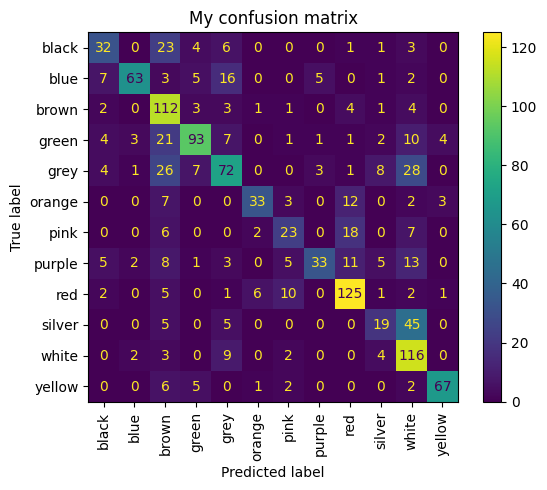

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(200,200))
cm = confusion_matrix(labels, predicts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuple(classes.values()))
disp.plot()
plt.title("My confusion matrix")
plt.xticks(rotation=90)
plt.show()